
`This notebook is made to predict cancer or healty Binary Classification Data by comparing and improving the Sequential and Functional ANN Model`

By : **Albert Novanto P J** (HCK-015)

## i. **Libraries**

In [1]:
#Basic libraries
import numpy as np
import pandas as pd
from time import strftime
import itertools
import random
import os
from os import walk
from os.path import join

#Visualization and image processing libraries
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import cv2

#ML libraries
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout

# To Ignore Warning
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal


# Library Model Saving
import pickle
import joblib
import json

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## ii. **Data Loading**

In [2]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'D:/hacktiv/fase 2/gc7/p2-ftds015-hck-g7-albertn15/brian/Brain Tumor'
healthy_dir=r'D:/hacktiv/fase 2/gc7/p2-ftds015-hck-g7-albertn15/brian/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy')

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  D:/hacktiv/fase 2/gc7/p2-ftds015-hck-g7-albert...  cancer
1  D:/hacktiv/fase 2/gc7/p2-ftds015-hck-g7-albert...  cancer
2  D:/hacktiv/fase 2/gc7/p2-ftds015-hck-g7-albert...  cancer
3  D:/hacktiv/fase 2/gc7/p2-ftds015-hck-g7-albert...  cancer
4  D:/hacktiv/fase 2/gc7/p2-ftds015-hck-g7-albert...  cancer
labels
cancer     2513
healthy    2087
Name: count, dtype: int64


In [3]:
#shape of datatset
tumor_df.shape

(4600, 2)

In [4]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [5]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


In [6]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


In [8]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

## iii. **EDA**

In [9]:
df_metadata=pd.read_csv('metadata.csv')

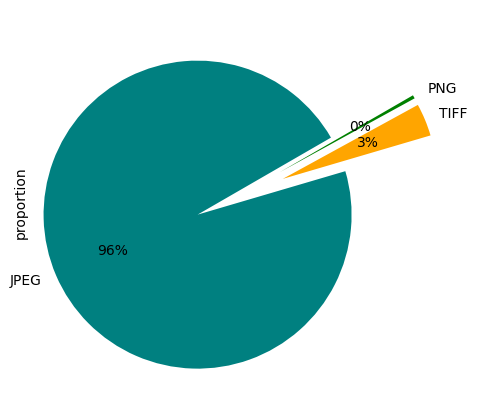

In [10]:
plt.figure(figsize=(5,5))
colors = ['teal', 'orange', 'green']
df_metadata[df_metadata['class']=='tumor']['format'].value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%',explode=(0.2,0.4,0.4),startangle=30,colors=colors);

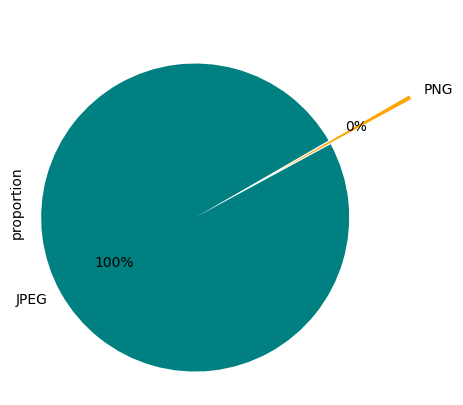

In [11]:
plt.figure(figsize=(5,5))
df_metadata[df_metadata['class']=='normal']['format'].value_counts(normalize=True).plot(kind='pie',explode=(0.2,0.4),autopct='%1.0f%%',startangle=30,colors=colors);

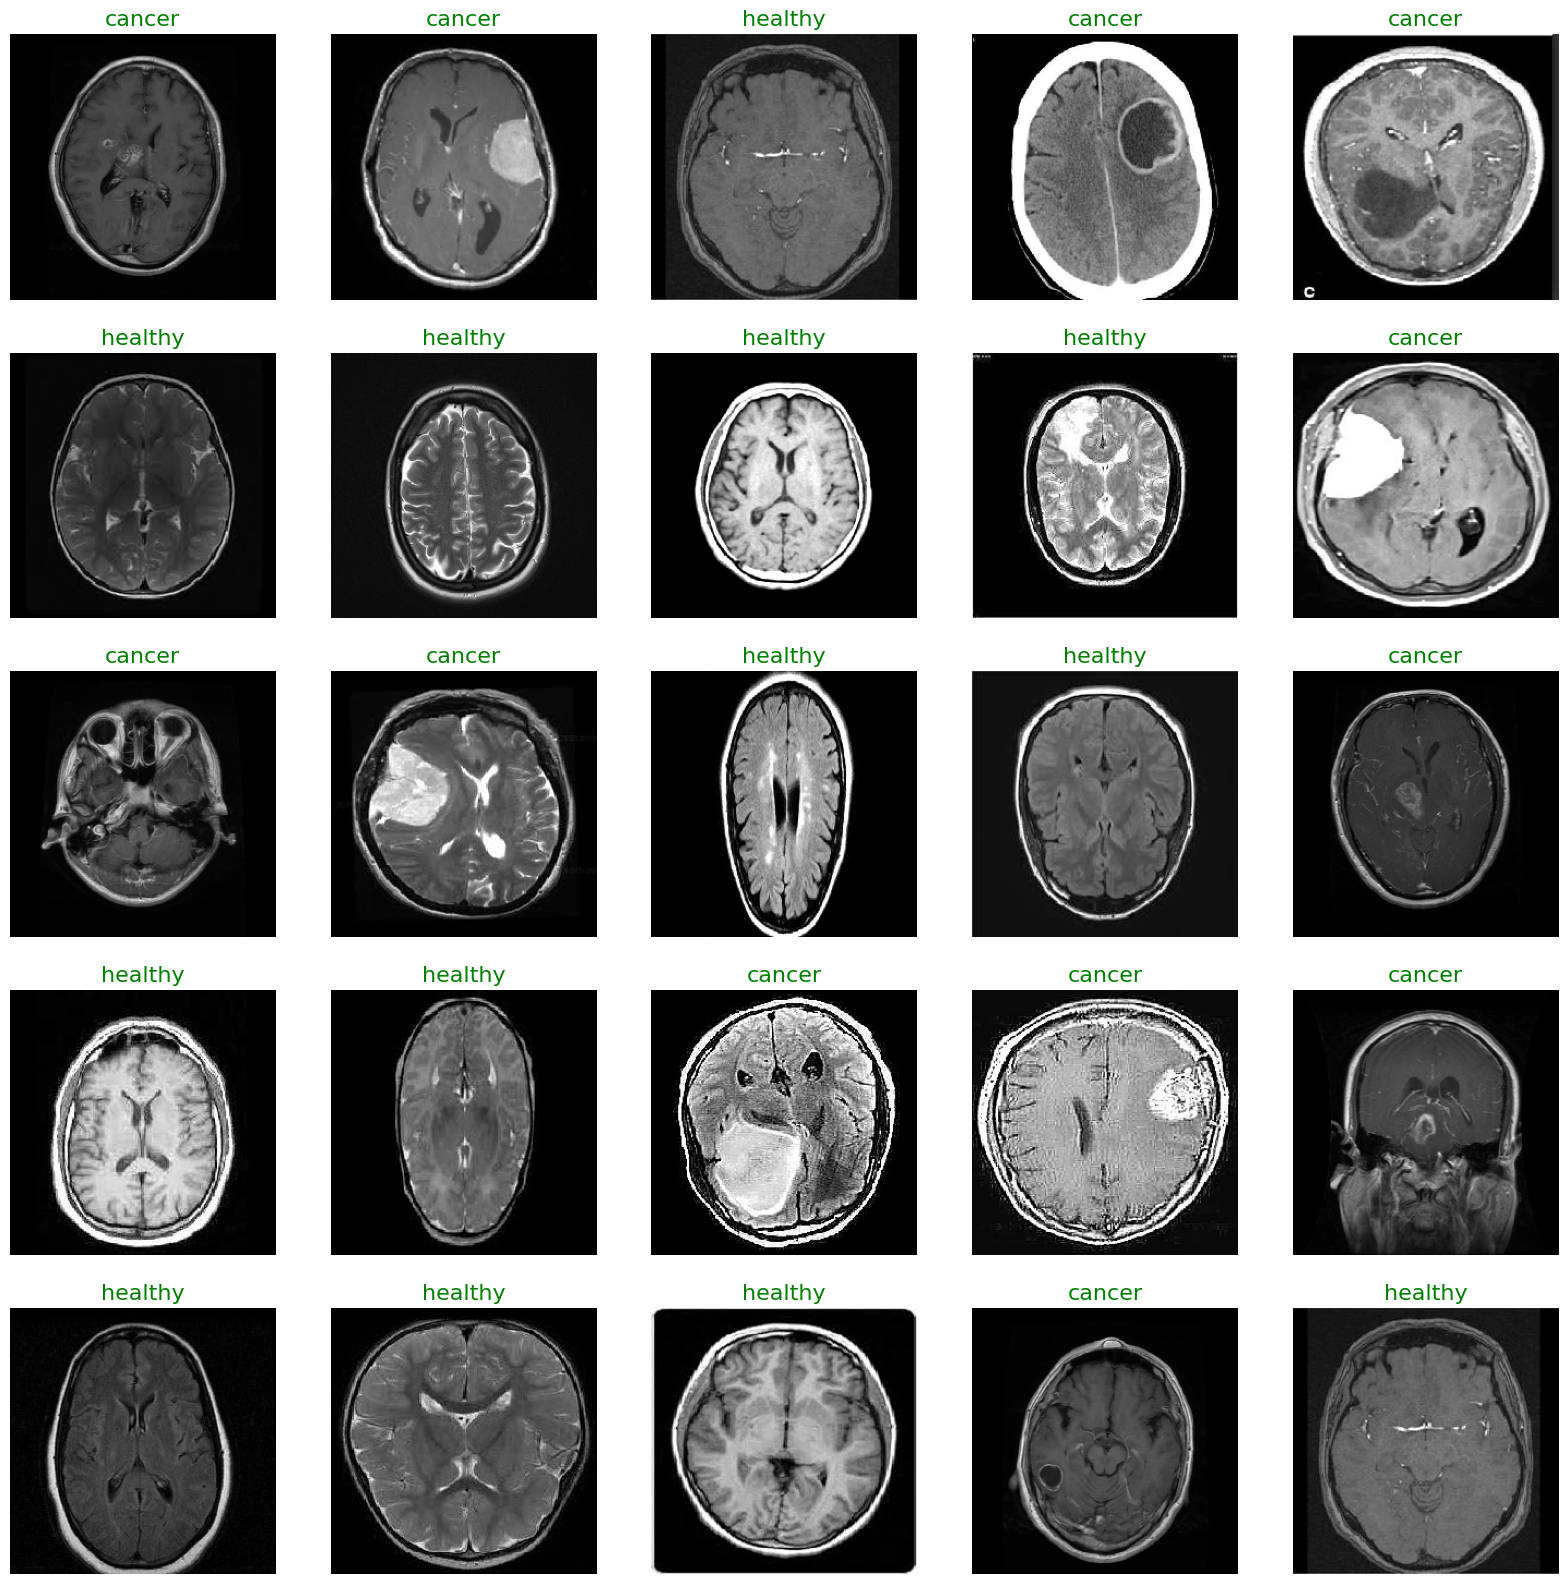

In [12]:
show_brain_images(train)

## iv. **Feature Engineering**

In [13]:
# Function to check image readability
def check_image_readability(folder_path):
    # Make empty list
    unreadable_images = []
    readable_images = []
    
    # Loop every image from file folder
    for file_path in tf.io.gfile.glob(folder_path + '/*'):
        try:
            # Read image
            with Image.open(file_path) as img:
                img.load()
            # Append readable image into the list
            readable_images.append(file_path)

        except (IOError, Image.DecompressionBombError) as e:
            print(f"Error reading {file_path}: {e}")
            # Append unreadable image into the list
            unreadable_images.append(file_path)
            # Remove the unreadable image from the folder
            os.remove(file_path)

    # Display the number of readable images and unreadable images
    if unreadable_images:
        print("There are unreadable images")
    else:
        print("All images are readable.")
    return unreadable_images, readable_images

In [14]:
# Check image readability from the fractured images in train set
unreadable_images_tumor_dir, readable_images_tumor_dir = check_image_readability(tumor_dir)
print(len(unreadable_images_tumor_dir), len(readable_images_tumor_dir))

All images are readable.
0 2513


**description** :

There are :
- 0 unreadable image
- 2513 readable image

In [15]:
# Check image readability from the non-fractured images in train set
unreadable_images_healthy_dir, readable_images_healthy_dir = check_image_readability(healthy_dir)
print(len(unreadable_images_healthy_dir), len(readable_images_healthy_dir))

All images are readable.
0 2087


**description** :

There are :
- 0 unreadable image
- 2087 readable image

## v. **Sequential API**

**explanation** :

These are some parameters used in the model :
1. Set **input shape of 244x244** based on the image generator with **3 color channel**
2. Use **`Sequential`** model for a simple and convenient way for deep learning
3. Use **relu** activation to **mitigate the vanishing gradient** problem 
4. Add **output layer** using Dense with 1 unit and **sigmoid** activation

In [16]:
#Defining Sequential Model
model = Sequential()
# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation="relu"))

#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 468512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    29,984,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,987,874 (114.39 MB)

 Trainable params: 29,987,874 (114.39 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Training**

**explanation** :

Compile CNN model with :
1. **`BinaryCrossentropy`** loss because the problem is a binary classification, where the model predict between 0 and 1
2. **`Adam optimizer`** because it adapts the learning rate for each parameter based on the gradient history, which can lead to a better performance
3. **`Accuracy`** metrics is used to measure the performance of the model 

Fit the model into :
1. Trains the model using the train dataset (train)
2. Use 10 epochs to avoid overfitting and underfitting
3. Validate the model using the validation dataset (val)

In [17]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.6334 - loss: 3.9444 - val_accuracy: 0.8098 - val_loss: 0.4340
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.8289 - loss: 0.4005 - val_accuracy: 0.8946 - val_loss: 0.2701
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.8946 - loss: 0.2599 - val_accuracy: 0.9402 - val_loss: 0.1960
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9402 - loss: 0.1634 - val_accuracy: 0.9576 - val_loss: 0.1527
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9601 - loss: 0.1270 - val_accuracy: 0.9141 - val_loss: 0.2064
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9617 - loss: 0.1225 - val_accuracy: 0.9565 - val_loss: 0.1370
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9725 - loss: 0.0745 - val_accuracy: 0.9533 - val_loss: 0.1555
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9675 - loss: 0

**summary** :

* The **training accuracy increased steadily** over the 10 epochs, starting at 56.87% and reaching `98.50%` by the end of training.
* The **training loss decreased steadily** over the 10 epochs, starting at 9.4126 and reaching `0.0428` by the end of training.
* The **validation accuracy also increased steadily** over the 10 epochs, starting at 78.80% and reaching `94.24%` by the end of training.
* The **validation loss decreased initially but then fluctuated** somewhat over the 10 epochs, starting at 0.4920 and ending at `0.1939`.

Note that **the model seem to overfit** as there is a difference in the training accuracy (98.50%) and validation accuracy (94.24%), with a difference of **`4.26%`**

### **Model Evaluation**

Text(0.5, 1.0, 'Training and Validation Accuracy')

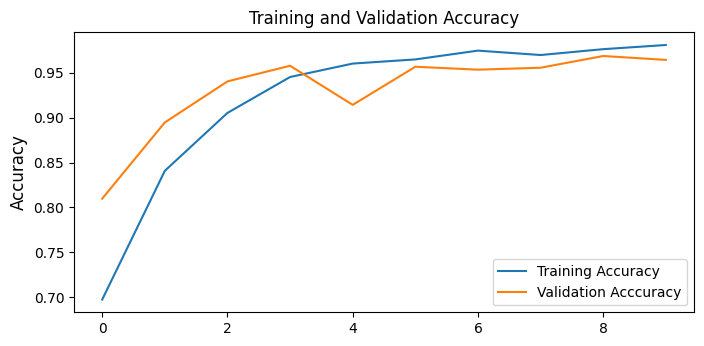

In [18]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

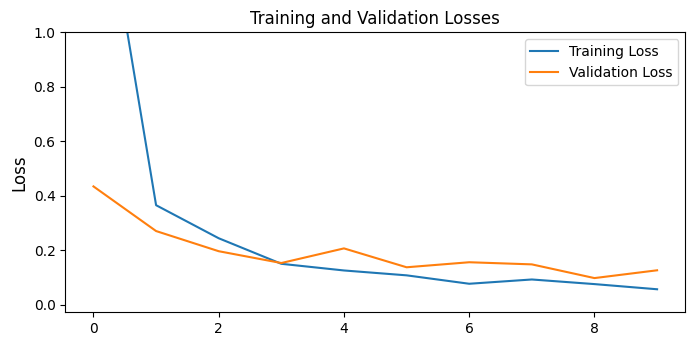

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

**summary** :

The low loss and high accuracy indicates **a good model performance**. The model seems to perform very well on the training data, achieving 100% accuracy at the first epoch. However, the accuracy on the validation data is lower, suggesting that **the model might be overfitting the training data**

To improve the model's performance, we can use techniques such as **regularization** and **early stopping**

In [20]:
model.evaluate(test, verbose=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9654 - loss: 0.1292


[0.0868937149643898, 0.9760869741439819]

In [21]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [22]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       0.98      0.98      0.98       779
     healthy       0.97      0.98      0.97       601

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380

Accuracy of the Model: 97.60869565217392 %


<Axes: >

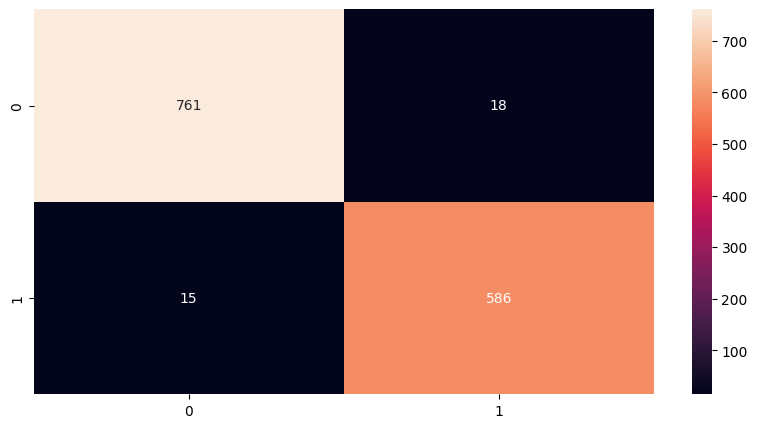

In [23]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')



## vi. Functional API

### **Model Definition**

**explanation** :

These are some parameters used in the model :
1. Set **input shape of 240x240** based on the image generator with **3 color channel**
2. Use **`Functional`** model for its **model flexibility** that might lead to a better performance than sequential
3. Use **relu** activation to **mitigate the vanishing gradient** problem 
4. Add **output layer** using Dense with 1 unit and **sigmoid** activation, as it is **commonly used for binary** classification

In [24]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# define input shape
input_shape = (244, 244, 3)

# define input layer
inputs = Input(shape=input_shape)

# define conv-pool layer
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="valid")(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)

# add flatten layer
x = Flatten()(x)

# add dense layers with dropout
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(32, activation="relu")(x)

# output layer
outputs = Dense(2, activation="sigmoid")(x)

# create model
model = Model(inputs=inputs, outputs=outputs)

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# summary
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 468512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │    29,984,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,987,874 (114.39 MB)

 Trainable params: 29,987,874 (114.39 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Training**

**explanation** :

Compile CNN model with :
1. **`BinaryCrossentropy`** loss because the problem is a binary classification, where the model predict between 0 and 1
2. **`Adam optimizer`** because it adapts the learning rate for each parameter based on the gradient history, which can lead to a better performance
3. **`Accuracy`** metrics is used to measure the performance of the model 

Fit the model into :
1. Trains the model using the train dataset (train)
2. Use 15 epochs to avoid overfitting and underfitting
3. Validate the model using the validation dataset (val)

In [25]:
# Compline model loss, optimizer and metrics
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit model into train set
history_2 = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.6157 - loss: 4.5956 - val_accuracy: 0.8217 - val_loss: 0.3800
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.8620 - loss: 0.3298 - val_accuracy: 0.8967 - val_loss: 0.2520
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9265 - loss: 0.1881 - val_accuracy: 0.9489 - val_loss: 0.1502
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9546 - loss: 0.1273 - val_accuracy: 0.9478 - val_loss: 0.1346
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.9730 - loss: 0.0799 - val_accuracy: 0.9674 - val_loss: 0.1055
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9763 - loss: 0.0651 - val_accuracy: 0.9630 - val_loss: 0.1188
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9752 - loss: 0.0504 - val_accuracy: 0.9641 - val_loss: 0.1644
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.9635 - loss: 0

**summary** :

* The **training accuracy increased steadily** over the 10 epochs, starting at 60.41% and reaching `98.79%` by the end of training.
* The **training loss decreased steadily** over the 10 epochs, starting at 5.3824 and reaching `0.0403` by the end of training.
* The **validation accuracy also increased steadily** over the 10 epochs, starting at 79.13% and reaching `96.85%` by the end of training.
* The **validation loss decreased initially but then fluctuated** somewhat over the 10 epochs, starting at 0.5348 and ending at `0.1310`.

Note that **the model seem to overfit** as there is a difference in the training accuracy (98.79%) and validation accuracy (96.85%), with a difference of **`0.40%`**

### **Model Evaluation**

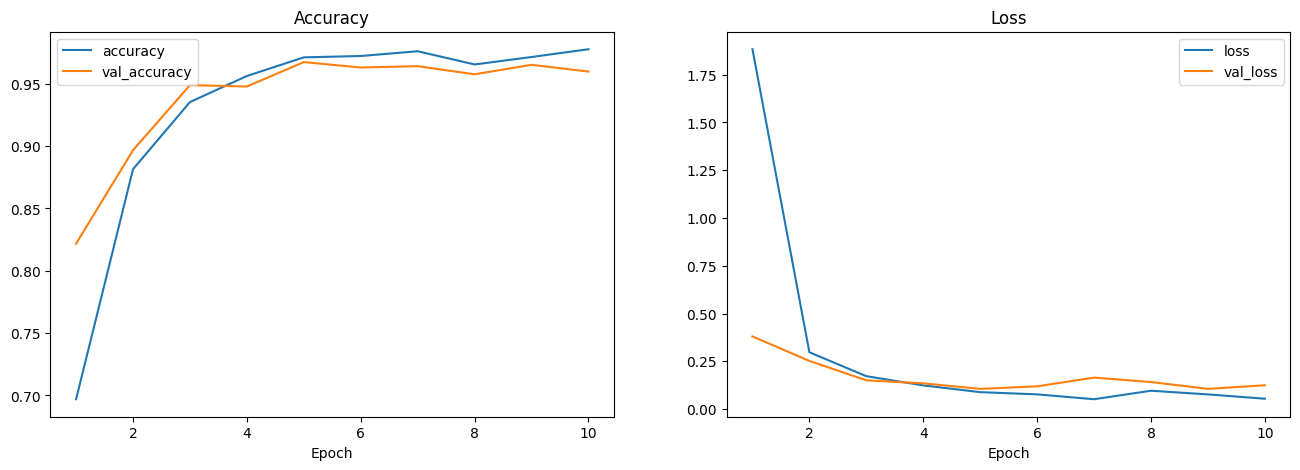

In [26]:
epoch = 10

# Make figure for subplot
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

# Make plot for accuracy vs val_accuracy
ax[0].plot(range(1,epoch+1),history_2.history['accuracy'],label='accuracy')
ax[0].plot(range(1,epoch+1),history_2.history['val_accuracy'],label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Make plot for loss vs val_loss
ax[1].plot(range(1,epoch+1),history_2.history['loss'],label='loss')
ax[1].plot(range(1,epoch+1),history_2.history['val_loss'],label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epoch')

# Show figure
plt.show()

**summary** :

The loss and high accuracy indicates **a relatively well model performance**. The model seems to perform well on the training data, achieving 90% accuracy at the end. However, the accuracy on the validation data is much lower, suggesting that **the model is overfitting the training data**

To improve the model's performance, we can use techniques such as **regularization** and **early stopping**

In [27]:
model.evaluate(test, verbose=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9585 - loss: 0.1334


[0.08981609344482422, 0.9717391133308411]

**Model Summary** :

| CNN Model      | Accuracy | Val Accuracy | Loss  | Val Loss | Accuracy Difference |
|----------------|----------|--------------|-------|----------|---------------------|
| **Sequential** | 98.50    | 94.24        | 0.042 | 0.193    | 4.26                |
| **Functional** | 98.79    | 96.85        | 0.040 | 0.131    | 1.94                |

To compare how each model performs, `a lower loss` and `higher accuracy` indicates a better model performance. Also, a `lower accuracy difference` indicates that the model is less likely to overfit.

From the table above, we can see that :
1. Training accuracy --> **`Sequential < Functional`**
2. Validation accuracy --> **`Sequential < Functional`**
3. Training loss --> **`Sequential > Functional`**
4. Validation loss --> **`Sequential > Functional`**
5. Accuracy difference --> **`Sequential > Functional`**

In conclusion, the **Functional CNN Model performs better** than the Sequential CNN Model.


## vii. **Model Improvement**

There are a few ways to reduce overfitting, such as :

1. `Kernel Initializer`: Determines how the kernel weights are initialized before training to improve the stability and speed of training.
2. `Padding` : Add extra rows and columns of zeros around the input data to prevent the loss of information at the borders of the input data
1. `Batch Normalization`: Add batch normalization layers after each convolutional layer to normalize the inputs and reduce overfitting.
3. `Early Stopping`: Implement early stopping to stop training when the model's performance on the validation set starts to degrade.

### **Model Definition**

In this model improvements, we are using :

1. `kernel_initializer= he_normal` because it is more suitable for ReLU compared to other initializer
2. `padding= same` because we want the output feature map to have the same spatial dimensions as the input data
3. `BatchNormalization` because we want to reduce overfitting

In [28]:
# Determine input shape
input_shape = (244, 244, 3)

# Define input layer
inputs = Input(shape=input_shape)

# Add convolution layer with batch normalization
x = Conv2D(32, (3, 3), 1, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
x = BatchNormalization()(x)
# Add pooling layer
x = MaxPooling2D()(x)

# Add another convolution layer with batch normalization
x = Conv2D(16, (3, 3), 1, activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
# Add another pooling layer
x = MaxPooling2D()(x)

# Add another convolution layer with batch normalization
x = Conv2D(32, (3, 3), 1, activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
# Add another pooling layer
x = MaxPooling2D()(x)

# Flatten the hidden layer
x = Flatten()(x)

# Add dropout layer
x = Dropout(0.5)(x) 

# Add dense layer with batch normalization
x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
# Add output layer
outputs = Dense(2, activation='sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)
# Display model summary
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 244, 244, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 244, 244, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 122, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │       460,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,394 (1.80 MB)

 Trainable params: 471,202 (1.80 MB)

 Non-trainable params: 192 (768.00 B)

### **Model Training**

**explanation** :

Add callbacks with early stopping :
1. `monitor= val_loss` because in the previous model, the val loss starts to degrade at the end of the training
2. `patience= 3` because we want to stop the model training if the val loss did not improve over 3 epochs

In [29]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Compile model loss, optimizer and metrics
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
# Fit model into train set
history_2 = model.fit(train, epochs=10, validation_data=val,batch_size=64, callbacks=[early_stopping])

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 210ms/step - accuracy: 0.7879 - loss: 0.4727 - val_accuracy: 0.6228 - val_loss: 0.8957
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 209ms/step - accuracy: 0.9440 - loss: 0.1930 - val_accuracy: 0.7533 - val_loss: 0.4818
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.9687 - loss: 0.1117 - val_accuracy: 0.9272 - val_loss: 0.1975
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.9857 - loss: 0.0696 - val_accuracy: 0.9598 - val_loss: 0.1120
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.9851 - loss: 0.0533 - val_accuracy: 0.9707 - val_loss: 0.0835
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - accuracy: 0.9965 - loss: 0.0272 - val_accuracy: 0.9674 - val_loss: 0.1015
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - accuracy: 0.9955 - loss: 0.0242 - val_accuracy: 0.9576 - val_loss: 0.1104
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - accuracy: 0.9966 - loss: 0

**summary** :

* The **training accuracy increased steadily** over the 10 epochs, starting at 99.48% and reaching `100.00%` by the end of training.
* The **training loss decreased steadily** over the 10 epochs, starting at 0.0159 and reaching `0.007` by the end of training.
* The **validation accuracy also increased steadily** over the 10 epochs, starting at 95.54% and reaching `98.15%` by the end of training.
* The **validation loss decreased initially but then fluctuated** somewhat over the 10 epochs, starting at 0.1631 and ending at `0.0846`.

Note that **the model seem to overfit** as there is a difference in the training accuracy (100.%) and validation accuracy (98.15%), with a difference of **`1.85%`**

### **Model Evaluation**

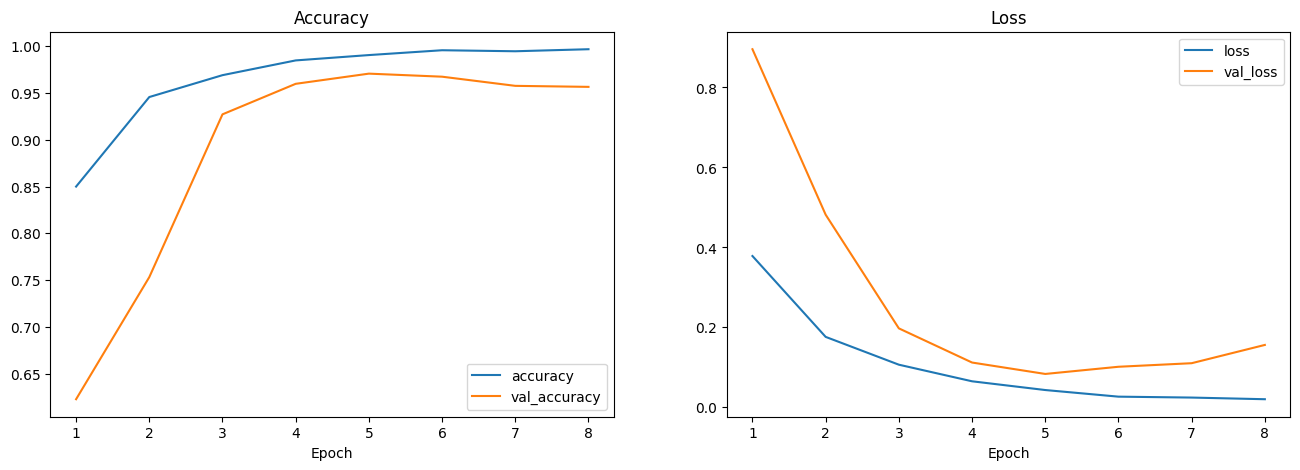

In [30]:
epoch = 8

# Make figure for subplot
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

# Make plot for accuracy vs val_accuracy
ax[0].plot(range(1,epoch+1),history_2.history['accuracy'],label='accuracy')
ax[0].plot(range(1,epoch+1),history_2.history['val_accuracy'],label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Make plot for loss vs val_loss
ax[1].plot(range(1,epoch+1),history_2.history['loss'],label='loss')
ax[1].plot(range(1,epoch+1),history_2.history['val_loss'],label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epoch')

# Show figure
plt.show()

In [31]:
# Predict test-set

model.evaluate(test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9616 - loss: 0.1473


[0.11403342336416245, 0.967391312122345]

**Model Summary** :

| CNN Model        | Accuracy | Val Accuracy | Loss  | Val Loss | Accuracy Difference |
|------------------|----------|--------------|-------|----------|---------------------|
| **Functional**   | 99.91    | 99.51        | 0.003 | 0.021    | 0.40                |
| **Improved CNN** | 99.97    | 98.54        | 0.002 | 0.065    | 1.43                |

From the table above, we can see that :
1. Training accuracy --> **`Improved Model > Functional`**
2. Validation accuracy --> **`Improved Model < Functional`**
3. Training loss --> **`Improved Model < Functional`**
4. Validation loss --> **`Improved Model > Functional`**
5. Accuracy difference --> **`Improved Model > Functional`**

In conclusion, while the Improved CNN model has a higher Accuracy, its lower Validation Accuracy suggests that it may be overfitting to the training data, making the Functional CNN model a potentially more reliable choice

## viii. **Model Inference**

### Random Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


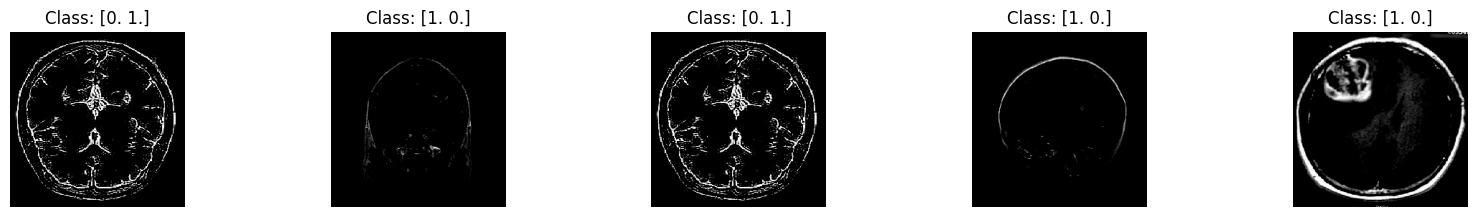

In [32]:
# Generate 5 random indices for the images
num_images = 5
batch = test.__next__()
idx = np.random.randint(len(batch[0]), size=num_images)

# Preprocess the images to match the input shape of the model
images = batch[0][idx]
class_labels = batch[1][idx]

# Display the images using matplotlib
plt.figure(figsize=(20, 5))
for i in range(num_images):
    plt.subplot(2, num_images, i+1)
    plt.imshow(images[i], cmap='bone')
    plt.title(f"Class: {class_labels[i]}")
    plt.axis('off')
plt.show()

**description** :

Figure above shows 5 random images from the test set, to test if the model can predict the pictures.

We can see above that the random images shows the class of `[1,0,0,0,0]` with :
- 1 defined as Cancer 
- 0defined as Healty

### Model Prediction

In [33]:
# Use the model to predict the images
predictions = model.predict(images)

# Post-process the predictions as needed
labels = np.zeros(num_images)
for i in range(num_images):
    if np.argmax(predictions[i]) == 1:
        labels[i] = 1
    else:
        labels[i] = 0

# Print the predictions
print(f'Predicted labels: {labels}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted labels: [1. 0. 1. 0. 0.]


**description** :

Output above shows the prediction the model made from the random images, we can see that the output shows the class of `[1, 0, 0, 0, 0]`.

In conclusion, **the model correctly predict the random images** from the test set and we can say that the model perform well

We can now save the model for deployment

In [34]:
# Save the model using joblib
joblib.dump(model, 'model.joblib')

['model.joblib']